# Put Pricing under the Black Scholes Model

Author: Jose Melo

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import norm
from optimizer import *
from nets import *
from matplotlib import cm
import json
import time
import matplotlib.colors as mcolors

%matplotlib widget

DTYPE = torch.float64
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(DTYPE)

## Parameters

In [2]:
STRIKE = 100
S_MIN, S_MAX =  0, 2*STRIKE
X_MIN, X_MAX = np.log((S_MIN+1e-4)/STRIKE), np.log(S_MAX/STRIKE)   

T     = 1.0      # years to expiry
K     = 100.0    # strike
r     = 0.03     # risk-free (flat)
q     = 0.00     # dividend yield
SIGMA = 0.20     # volatility

In [3]:
def sample_domain(n_int=25_000, n_bdry=25_000, n_pay=25_000):
    # interior ----------------------------------------------------
    inter       = np.random.rand(n_int, 2)
    inter[:, 0] = inter[:, 0] * T                       
    inter[:, 1] = inter[:, 1]*(X_MAX-X_MIN) + X_MIN 

    # bottom boundary  x = X_MIN ------------------------------
    bot         = np.random.rand(n_bdry, 2)
    bot[:, 0]   = bot[:, 0] * T
    bot[:, 1]   = X_MIN

    # top boundary  x = X_MAX -------------------------------
    top         = np.random.rand(n_bdry, 2)
    top[:, 0]   = top[:, 0] * T
    top[:, 1]   = X_MAX

    # terminal condition  tau = 0 ------------------------------
    pay         = np.random.rand(n_pay, 2)
    pay[:, 0]   = 0.0
    pay[:, 1]   = pay[:, 1]*(X_MAX-X_MIN) + X_MIN

    X = np.vstack([inter, bot, top, pay])
    return torch.tensor(X, dtype=DTYPE, device=DEV)

In [4]:
def pde_residual(model, X):    
    X.requires_grad_(True)
    V      = model(X)
    grads  = torch.autograd.grad(V.sum(), X, create_graph=True)[0]
    V_tau, V_x  = grads[:, 0], grads[:, 1]
    V_xx        = torch.autograd.grad(V_x.sum(), X, create_graph=True)[0][:, 1]
    return V_tau - 0.5 * SIGMA**2 * (V_xx - V_x) - r * V_x + r * V

def pde_loss(model, X):        
    pde = pde_residual(model, X)    
    return pde.pow(2).mean()

def loss_fn(model, X):
    tau, x = X.t()
    interior = (tau > 0) & (tau < T) & (x > X_MIN) & (x < X_MAX)
    bot     = x == X_MIN
    top     = x == X_MAX
    payoff  = tau == 0

    # interior
    l_int = pde_loss(model, X[interior])

    X_top = X[top].requires_grad_(True)
    V_top = model(X_top)
    Vtau_top = torch.autograd.grad(V_top.sum(), X_top, create_graph=True)[0][:, 0]
    l_top = (-Vtau_top - r * V_top).pow(2).mean()

    X_bot = X[bot].requires_grad_(True)
    V_bot = model(X_bot)
    Vx_bot = torch.autograd.grad(V_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    Vxx_bot = torch.autograd.grad(Vx_bot.sum(), X_bot, create_graph=True)[0][:, 1]
    l_bot = (Vxx_bot - Vx_bot).pow(2).mean()

    # payoff
    x_pay = x[payoff]
    payoff_val = torch.maximum(1.0 - torch.exp(x_pay), torch.zeros_like(x_pay))
    l_pay = (model(X[payoff]) - payoff_val).pow(2).mean()

    print("loss int {:8.2e}  bot {:8.2e}  top {:8.2e}  pay {:8.2e}".format(l_int.item(), l_bot.item(), l_top.item(), l_pay.item()))
    return l_int, l_bot, l_top, l_pay

## Training

In [5]:
X = sample_domain()

In [6]:
model = MLP(in_dim=2, hidden_layers=[20, 20], out_dim=1).to(DEV)
for p in model.parameters():
    if p.dim()>1: nn.init.xavier_uniform_(p)

In [67]:
opt = SSBroyden(model.parameters(), max_iter=20_000, tolerance_change=1e-10, tolerance_grad=1e-10)

benchmark = {'Interior': [], 'Bottom': [], 'Top': [], 'Payoff': [], 'Total': [], 'time': 0.0}
def closure(*args, **kwargs):
    opt.zero_grad()
    l_int, l_bot, l_top, l_pay = loss_fn(model, X)
    loss = l_int + l_bot + l_top + l_pay
    benchmark["Interior"].append(l_int.item())
    benchmark["Bottom"].append(l_bot.item())
    benchmark["Top"].append(l_top.item())
    benchmark["Payoff"].append(l_pay.item())
    benchmark["Total"].append(loss.item())  
    loss.backward()    
    return loss

start = time.time()
opt.step(closure)
end = time.time()
benchmark["time"] = end - start
print("training finished")

loss int 4.16e-03  bot 8.51e-02  top 2.24e-03  pay 4.16e+00
loss int 2.41e-03  bot 3.66e-02  top 2.04e-03  pay 1.49e+00
loss int 2.41e-03  bot 3.66e-02  top 2.04e-03  pay 1.49e+00
loss int 2.67e-03  bot 3.72e-02  top 1.82e-03  pay 1.36e+00
loss int 6.30e-03  bot 3.06e-02  top 4.56e-04  pay 3.59e-01
loss int 6.30e-03  bot 3.06e-02  top 4.56e-04  pay 3.59e-01
loss int 6.35e-03  bot 2.65e-02  top 4.48e-04  pay 2.77e-01
loss int 6.35e-03  bot 2.65e-02  top 4.48e-04  pay 2.77e-01
loss int 6.39e-03  bot 2.60e-02  top 4.51e-04  pay 2.72e-01
loss int 6.74e-03  bot 2.17e-02  top 4.75e-04  pay 2.25e-01
loss int 1.01e-02  bot 1.42e-03  top 6.97e-04  pay 4.77e-02
loss int 1.01e-02  bot 1.42e-03  top 6.97e-04  pay 4.77e-02
loss int 9.94e-03  bot 1.40e-03  top 7.11e-04  pay 4.75e-02
loss int 8.69e-03  bot 1.17e-03  top 8.47e-04  pay 4.61e-02
loss int 1.06e-03  bot 3.84e-06  top 2.82e-03  pay 3.68e-02
loss int 1.06e-03  bot 3.84e-06  top 2.82e-03  pay 3.68e-02
loss int 8.65e-04  bot 3.22e-06  top 2.8

In [68]:
with open("put.json", "w") as f:
    json.dump(benchmark, f, indent=4)
torch.save(model.state_dict(), "put.pt")

In [7]:
model.load_state_dict(torch.load("put.pt"))
benchmark = json.load(open("put.json"))

In [8]:
model.eval()
with torch.no_grad():
    tau = torch.linspace(0, T, 100, device=DEV)
    x = torch.linspace(X_MIN, X_MAX, 100, device=DEV)
    t = (1-tau)*T
    s = STRIKE * torch.exp(x)
    tau, x = torch.meshgrid(tau, x, indexing="ij")

    x = torch.stack([tau.reshape(-1), x.reshape(-1)], dim=1)
    u = model(x).reshape(tau.shape)
    v_pinn = u*STRIKE


### Loss Evolution

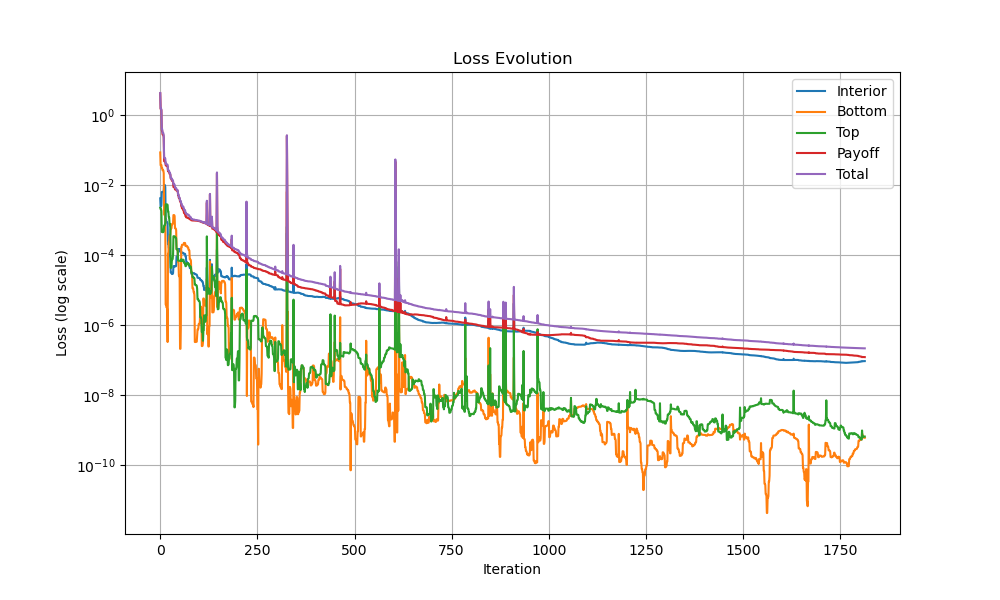

In [9]:
plt.figure(figsize=(10, 6))
for k,v in benchmark.items():
    if k != "time":
        plt.plot(v, label=k)
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.yscale('log')
plt.title("Loss Evolution")
plt.legend()
plt.grid()
plt.show()

### Exact Solution

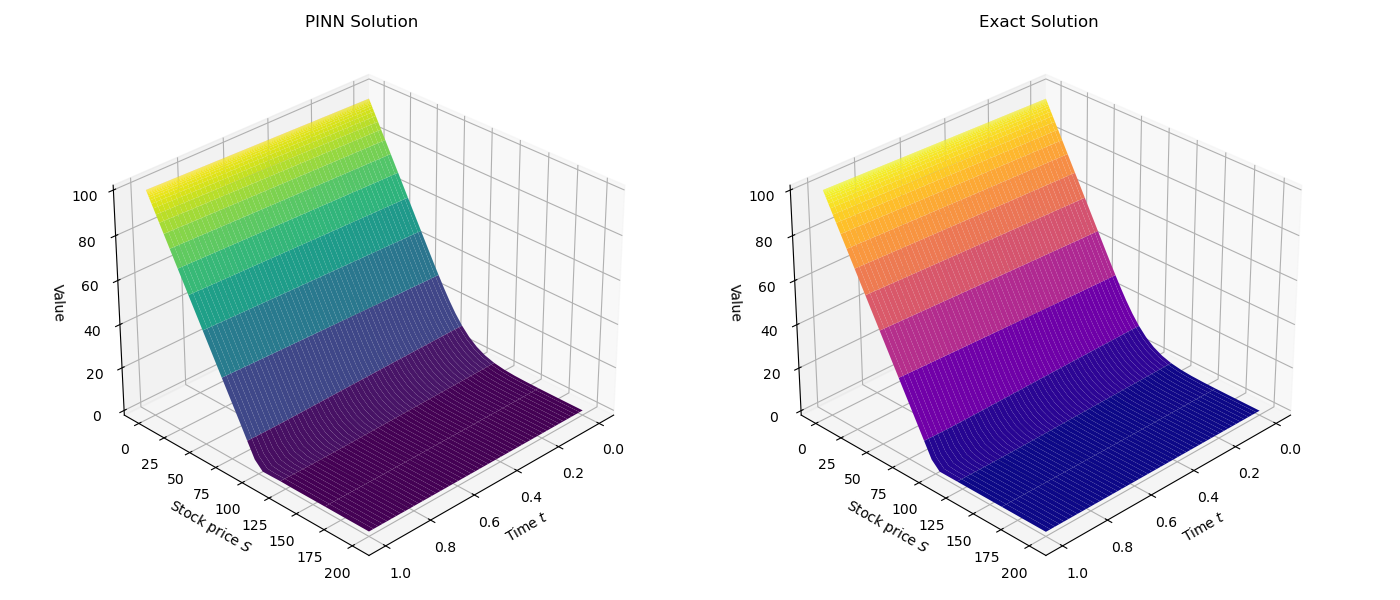

In [10]:
with torch.no_grad():
    n_t, n_x = 200, 200
    tau_vec  = torch.linspace(0.0, T, n_t, device=DEV)           # tau = T − t
    x_vec  = torch.linspace(X_MIN, X_MAX, n_x, device=DEV)
    tau_t, x_t = torch.meshgrid(tau_vec, x_vec, indexing="ij")

    X_grid = torch.stack([tau_t.reshape(-1), x_t.reshape(-1)], dim=1)
    V_pinn = model(X_grid).reshape(tau_t.shape) * STRIKE         # (torch)

    tau_np   = tau_t.cpu().numpy()
    x_np   = x_t.cpu().numpy()
    S_np   = STRIKE * np.exp(x_np)
    sqrttau  = np.sqrt(np.maximum(tau_np, 1e-12))

d1 = (np.log(S_np / STRIKE) + (r - q + 0.5*SIGMA**2) * tau_np) / (SIGMA * sqrttau)
d2 = d1 - SIGMA * sqrttau
V_bs_np = (STRIKE * np.exp(-r * tau_np) * norm.cdf(-d2)
           - S_np * np.exp(-q * tau_np) * norm.cdf(-d1))

V_pinn_np = V_pinn.cpu().numpy()
err_np    = np.abs(V_pinn_np - V_bs_np)

t_np = T - tau_np   

fig = plt.figure(figsize=(14, 6))

# (1) PINN surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(t_np, S_np, V_pinn_np, cmap=cm.viridis)
ax1.view_init(elev=30, azim=45)
ax1.set_title('PINN Solution')
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Stock price $S$')
ax1.set_zlabel('Value')

# (2) Black–Scholes surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(t_np, S_np, V_bs_np, cmap=cm.plasma)
ax2.view_init(elev=30, azim=45)

ax2.set_title('Exact Solution')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Stock price $S$')
ax2.set_zlabel('Value')

fig.tight_layout()
plt.show()


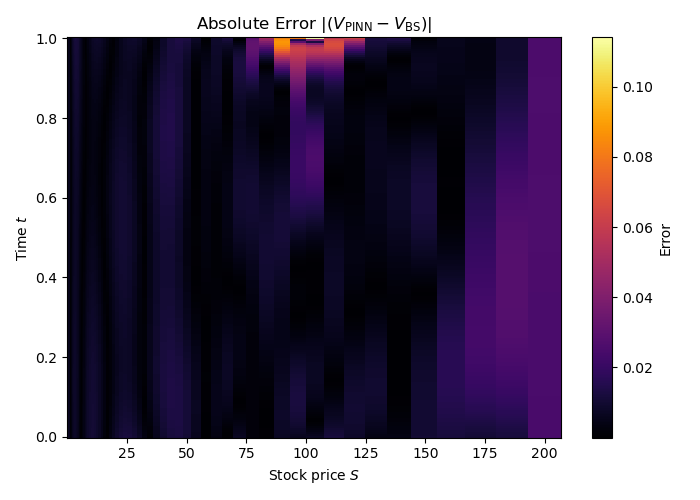

In [11]:
fig2 = plt.figure(figsize=(7, 5))
ax    = fig2.add_subplot(111)

cmesh = ax.pcolormesh(S_np, t_np, err_np,
                      shading='auto', cmap='inferno')

ax.set_title(r'Absolute Error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})|$')
ax.set_xlabel('Stock price $S$')
ax.set_ylabel('Time $t$')

fig2.colorbar(cmesh, ax=ax, label='Error')
fig2.tight_layout()
plt.show()

In [14]:
np.linalg.norm(V_pinn_np - V_bs_np, ord=2) / np.linalg.norm(V_bs_np, ord=2)

np.float64(5.855975734249282e-05)

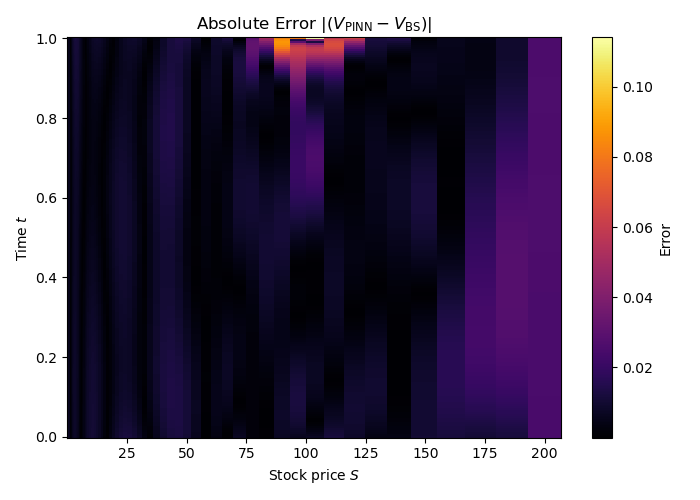

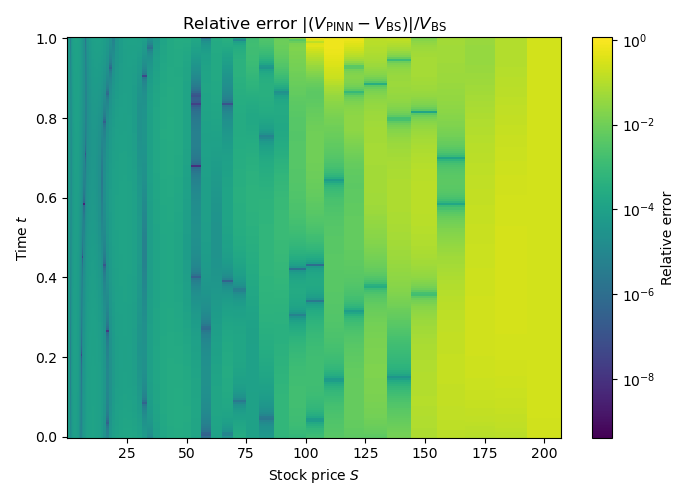

In [12]:
fig2 = plt.figure(figsize=(7, 5))
ax    = fig2.add_subplot(111)

cmesh = ax.pcolormesh(S_np, t_np, err_np,
                      shading='auto', cmap='inferno')

ax.set_title(r'Absolute Error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})|$')
ax.set_xlabel('Stock price $S$')
ax.set_ylabel('Time $t$')

fig2.colorbar(cmesh, ax=ax, label='Error')
fig2.tight_layout()
plt.show()

# --- relative error ---------------------------------------------------------
# Avoid division by zero: wherever V_bs_np == 0 put NaN (or a small epsilon)
eps = 1e-1                 # pick something ≪ typical option value
den  = np.maximum(np.abs(V_bs_np), eps)
rel_err_np  = np.abs(V_pinn_np - V_bs_np) / den
rel_err_pct = 100 * rel_err_np


# --- plot -------------------------------------------------------------------
fig3 = plt.figure(figsize=(7, 5))
ax3  = fig3.add_subplot(111)

# A log-colour scale makes the small errors visible
log_norm = mcolors.LogNorm(vmin=np.nanmin(rel_err_np[rel_err_np>0]),
                           vmax=np.nanmax(rel_err_np))

cmesh = ax3.pcolormesh(S_np, t_np, rel_err_np,
                       shading='auto',
                       cmap='viridis',
                       norm=log_norm)         # <- log scale

ax3.set_title(r'Relative error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})| / V_{\mathrm{BS}}$')
ax3.set_xlabel('Stock price $S$')
ax3.set_ylabel('Time $t$')

cb = fig3.colorbar(cmesh, ax=ax3, label='Relative error')
cb.update_ticks()

fig3.tight_layout()
plt.show()

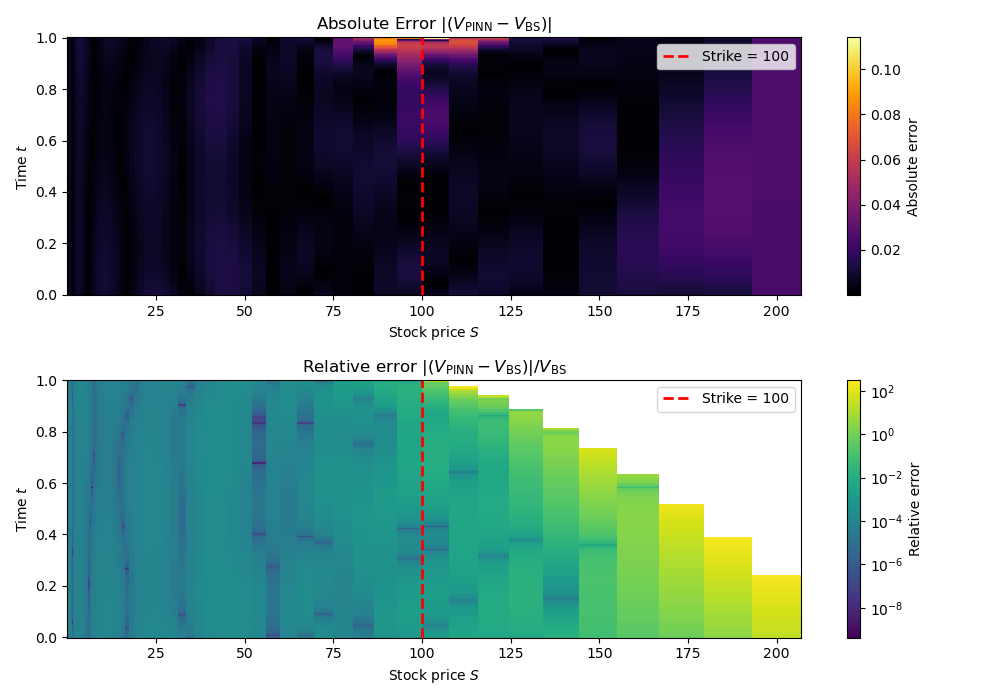

In [13]:
fig2 = plt.figure(figsize=(10, 7))
eps = 1e-4
rel_err_np = np.abs(V_pinn_np - V_bs_np) / np.where(np.abs(V_bs_np) > eps,
                                                    V_bs_np,
                                                    np.nan)           # shape (n_t, n_x)

# Optional: turn it into % if you like
rel_err_pct = 100 * rel_err_np

# Absolute error plot
ax1 = fig2.add_subplot(2, 1, 1)
cmesh1 = ax1.pcolormesh(S_np, t_np, err_np, cmap='inferno')
ax1.set_title(r'Absolute Error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})|$')
ax1.set_xlabel('Stock price $S$')
ax1.set_ylabel('Time $t$')
ax1.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2, label=f'Strike = {STRIKE}')
ax1.legend()
fig2.colorbar(cmesh1, ax=ax1, label='Absolute error')

# Relative error plot
ax2 = fig2.add_subplot(2, 1, 2)
log_norm = mcolors.LogNorm(vmin=np.nanmin(rel_err_np[rel_err_np>0]),
                           vmax=np.nanmax(rel_err_np))
cmesh2 = ax2.pcolormesh(S_np, t_np, rel_err_np,
                       cmap='viridis',
                       norm=log_norm)
ax2.set_title(r'Relative error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})| / V_{\mathrm{BS}}$')
ax2.set_xlabel('Stock price $S$')
ax2.set_ylabel('Time $t$')
ax2.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2, label=f'Strike = {STRIKE}')
ax2.legend()
cb = fig2.colorbar(cmesh2, ax=ax2, label='Relative error')
cb.update_ticks()

fig2.tight_layout()
plt.show()